# Can You Find The Best Dungeons & Dragons Strategy?
From https://fivethirtyeight.com/features/can-you-find-the-best-dungeons-dragons-strategy/

The fifth edition of Dungeons & Dragons introduced a system of “advantage and disadvantage.” When you roll a die “with advantage,” you roll the die twice and keep the higher result. Rolling “with disadvantage” is similar, except you keep the lower result instead. The rules further specify that when a player rolls with both advantage and disadvantage, they cancel out, and the player rolls a single die. Yawn!

There are two other, more mathematically interesting ways that advantage and disadvantage could be combined. First, you could have “advantage of disadvantage,” meaning you roll twice with disadvantage and then keep the higher result. Or, you could have “disadvantage of advantage,” meaning you roll twice with advantage and then keep the lower result. With a fair 20-sided die, which situation produces the highest expected roll: advantage of disadvantage, disadvantage of advantage or rolling a single die?

Extra Credit: Instead of maximizing your expected roll, suppose you need to roll N or better with your 20-sided die. For each value of N, is it better to use advantage of disadvantage, disadvantage of advantage or rolling a single die?

## Solution using probability

Let's see the problem using combinations

In [1]:
# store roll probability in an array with tuple (number, prob_num, prob_den)

single_roll = [(i,1,20) for i in range(1,21)]

def combine_probs(roll, decision):
    # temporary store numerators in in array[21], the first is always empty
    numerators = [0] * 21
    #denominator is the product of denominator
    denominator = roll[0][2]**2
    for i in roll:
        for j in roll:
            numerators[decision(i[0], j[0])] += i[1] * j[1]
    return [(i, numerators[i], denominator) for i in range(1,21)]

advantage_roll = combine_probs(single_roll, lambda x,y: max(x,y))
disadvantage_roll = combine_probs(single_roll, lambda x,y: min(x,y))

In [2]:
disadvantage_of_advantage_roll = combine_probs(advantage_roll, lambda x,y: min(x,y))
advantage_of_disadvantage_roll = combine_probs(disadvantage_roll, lambda x,y: max(x,y))
rolls = {
    'single_r': single_roll,
    'adv_r': advantage_roll,
    'dis_r': disadvantage_roll,
    'dis_of_adv_r': disadvantage_of_advantage_roll,
    'adv_of_dis_r': advantage_of_disadvantage_roll,
}

Plot the result to see if it makes sense and for visual reference

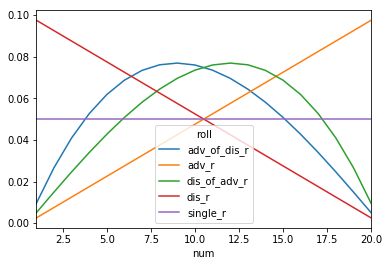

In [3]:
%matplotlib inline
import pandas as pd
df_p = pd.DataFrame(((k,j[0],j[1]/j[2]) for k,v in rolls.items() for j in v),
                  columns = ['roll','num','prob'])

df_p = df_p.pivot(index='num', columns='roll', values='prob')
df_p.plot()

### Expected Value

In [4]:
# Expected value of each roll
df_p.apply(lambda x:x*x.index).sum()

roll
adv_of_dis_r     9.833338
adv_r           13.825000
dis_of_adv_r    11.166662
dis_r            7.175000
single_r        10.500000
dtype: float64

So the most advantageous strategy when combining advantage and disadvantage is **disadvantage of advantage**

This makes sense from an intuitive point of view because you are taking the minimum of "two rolls" that are already skewed for returning an high result (although if we see the graph above we could notice that it is harder than a single roll to get an high value)

### Extra Credit: Probability of getting N or higher

This is basically the inverse of the cumulative probability. Obviously, if N = 1 the probability is always one and all the strategies are equivalent

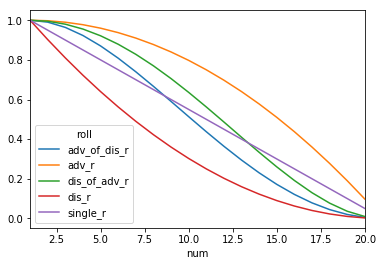

In [5]:
# Probability of getting N or higher
df_cum_h = df_p.apply(lambda x:x.sort_index(ascending=False).cumsum().sort_index())
df_cum_h.plot()

Only with the relevant lines

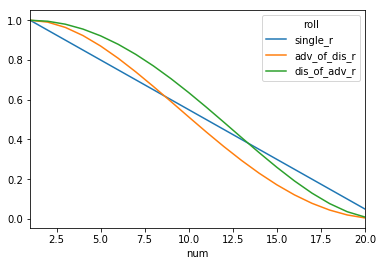

In [6]:
df_cum_h[['single_r', 'adv_of_dis_r', 'dis_of_adv_r']].plot()

In [7]:
df_cum_h[['single_r', 'adv_of_dis_r', 'dis_of_adv_r']].apply(
    lambda x:pd.Series([x.idxmax(), x.max()], index = ['strategy', 'probability']), axis=1)

,strategy,probability
num,,
1,single_r,1.000000
2,dis_of_adv_r,0.995006
3,dis_of_adv_r,0.980100
4,dis_of_adv_r,0.955506
5,dis_of_adv_r,0.921600
6,dis_of_adv_r,0.878906
7,dis_of_adv_r,0.828100
8,dis_of_adv_r,0.770006
9,dis_of_adv_r,0.705600


From both the chart and the table, we could see that **disadvantage of advantage** beats **single roll** for N up to 13. If I need to roll 14 or any number higher then 14, single roll is the most advantageous. From the chart above we could see that **advantage of disadvantage** is always beaten by **disadvantage of advantage** but beats **single roll** for small N (up to N=8)

## Solution running a simulation

This time, let's simulate the problem. We will try to roll every strategy 1 million time and see what happens

In [8]:
import random
random.seed(123) #fix random so always repeatable

r = lambda :random.randint(1,20)
a_r = lambda :max(r(),r())
d_r = lambda :min(r(),r())
aod_r = lambda :max(d_r(),d_r())
doa_r = lambda :min(a_r(),a_r())

In [9]:
def roll_dice_sim(f, it=1000000):
    ret = {i:0 for i in range(1,21)}
    for _ in range(it):
        ret[f()] += 1
    return {k: v/it for k,v in ret.items()}

In [10]:
data = {
    'single_r': roll_dice_sim(r),
    'adv_r': roll_dice_sim(a_r),
    'dis_r': roll_dice_sim(d_r),
    'adv_of_dis_r': roll_dice_sim(aod_r),
    'dis_of_adv_r': roll_dice_sim(doa_r),
}

In [11]:
df_p_sim = pd.DataFrame(((k1,k2,v2) for k1,v1 in data.items() for k2,v2 in v1.items()),
                  columns = ['roll','num','prob'])
df_p_sim = df_p_sim.pivot(index='num', columns='roll', values='prob')

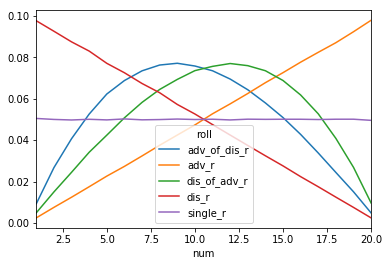

In [12]:
df_p_sim.plot()

Visually the results are identical (there are some differences due to the fact that the simulation is never perfect but the trend of each strategy matches)

### Expected Value

The results match, the best one is still **disadvantage of advantage**

In [13]:
# Expected value of each roll
df_p_sim.apply(lambda x:x*x.index).sum()

roll
adv_of_dis_r     9.829560
adv_r           13.823763
dis_of_adv_r    11.170467
dis_r            7.173604
single_r        10.495966
dtype: float64

### Extra credit

This one also matches with **disadvantage of advantage** beating **single roll** for N up to 13.

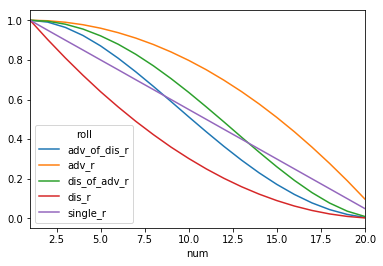

In [14]:
# Probability of getting N or higher
df_cum_h_sim = df_p_sim.apply(lambda x:x.sort_index(ascending=False).cumsum().sort_index())
df_cum_h_sim.plot()

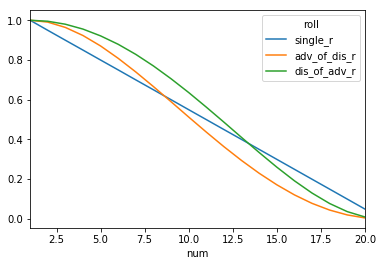

In [15]:
df_cum_h_sim[['single_r', 'adv_of_dis_r', 'dis_of_adv_r']].plot()

In [16]:
df_cum_h_sim[['single_r', 'adv_of_dis_r', 'dis_of_adv_r']].apply(
    lambda x:pd.Series([x.idxmax(), x.max()], index = ['strategy', 'probability']), axis=1)

,strategy,probability
num,,
1,adv_of_dis_r,1.000000
2,dis_of_adv_r,0.995023
3,dis_of_adv_r,0.979998
4,dis_of_adv_r,0.955502
5,dis_of_adv_r,0.921341
6,dis_of_adv_r,0.878931
7,dis_of_adv_r,0.828149
8,dis_of_adv_r,0.769922
9,dis_of_adv_r,0.705462
